In [ ]:
""" Symbolically solve the system of equations to express everything in
    [H+]. Then, use the numerical solver to just find pH. This vastly reduces
    the LUT size. 
"""
import sympy as sp

# Define the symbolic variables
h, oh, hco3, co3, ca, mg, na, k, al = sp.symbols('h oh hco3 co3 ca mg na k al')

# Define the parameters
b0, co2_atm, beta_h, beta1, beta2, beta3, beta4, beta5, kex1, kex2, kex3, kex4, kex5 = sp.symbols('b0 co2_atm beta_h beta1 beta2 beta3 beta4 beta5 kex1 kex2 kex3 kex4 kex5')
valence_Ca2, valence_Mg2, valence_Na, valence_K, valence_Al3 = sp.symbols('valence_Ca2 valence_Mg2 valence_Na valence_K valence_Al3')

# Define the equations
eq1 = sp.Eq(h * hco3 / co2_atm, 10**(-7.8136))
eq2 = sp.Eq(h * co3 / hco3, 10**(-10.3288))
eq3 = sp.Eq(h * oh, 1e-14)
eq4 = sp.Eq(h / beta_h * (beta1 / ca)**(1/valence_Ca2), kex1) # 10**(3.4*(1-beta_h)) *  
eq5 = sp.Eq(h / beta_h * (beta2 / mg)**(1/valence_Mg2), kex2) # 10**(3.4*(1-beta_h)) *  
eq6 = sp.Eq(h / beta_h * (beta3 / na)**(1/valence_Na), kex3) # 10**(3.4*(1-beta_h)) * 
eq7 = sp.Eq(h / beta_h * (beta4 / k)**(1/valence_K), kex4) # 10**(3.4*(1-beta_h)) * 
eq8 = sp.Eq(h / beta_h * (beta5 / al)**(1/valence_Al3), kex5) # 10**(3.4*(1-beta_h)) * 
eq9 = sp.Eq(h - oh - hco3 - 2*co3 + 2*ca + 2*mg + na + k + 3*al, b0)

# Carbonate precipitation constraint
# eq10 = sp.Eq(co3 * ca, 10**(-8.48))

# h - oh - hco3 - 2*co3 + 2*ca + 2*mg + na + k + 3*al + nh4 - no3 - 2*so4 - cl = 0

# E/P | ET/P ratio => Anions become more concentrated

# Solve the equations symbolically for the unknowns in terms of h
solutions = sp.solve((eq1, eq2, eq3, eq4, eq5, eq6, eq7, eq8, eq9), (oh, hco3, co3, ca, mg, na, k, al))

# Display the solutions
solutions

In [ ]:
# Calculate the derivative of the net charge balance
objective_expr = 0.333333333333333*b0 - 0.666666666666667*beta1/((1-beta1-beta2-beta3-beta4-beta5)*kex1/h)**valence_Ca2 - 0.666666666666667*beta2/((1-beta1-beta2-beta3-beta4-beta5)*kex2/h)**valence_Mg2 - 0.333333333333333*beta3/((1-beta1-beta2-beta3-beta4-beta5)*kex3/h)**valence_Na - 0.333333333333333*beta4/((1-beta1-beta2-beta3-beta4-beta5)*kex4/h)**valence_K + 5.12010356128343e-9*co2_atm/h + 4.80295746943524e-19*co2_atm/h**2 - 0.333333333333333*h + 3.33333333333333e-15/h - beta5/((1-beta1-beta2-beta3-beta4-beta5)*kex5/h)**valence_Al3

[sp.diff(objective_expr, beta1),
 sp.diff(objective_expr, beta2),
 sp.diff(objective_expr, beta3),
 sp.diff(objective_expr, beta4),
 sp.diff(objective_expr, beta5)]

In [ ]:
soil_ph = sp.symbols('soil_ph')

objective_expr = 0.333333333333333*b0 - 0.666666666666667*beta1/(beta_h*kex1/10**(-soil_ph))**valence_Ca2 - 0.666666666666667*beta2/(beta_h*kex2/10**(-soil_ph))**valence_Mg2 - 0.333333333333333*beta3/(beta_h*kex3/10**(-soil_ph))**valence_Na - 0.333333333333333*beta4/(beta_h*kex4/10**(-soil_ph))**valence_K + 5.12010356128343e-9*co2_atm/10**(-soil_ph) + 4.80295746943524e-19*co2_atm/10**(-soil_ph)**2 - 0.333333333333333*h + 3.33333333333333e-15/10**(-soil_ph) - beta5/(beta_h*kex5/10**(-soil_ph))**valence_Al3

print(sp.diff(objective_expr, soil_ph))

## Create the lookup table

This have to be run over a computational node; jupyter note book is extremely slow

In [1]:
import numpy as np

valence = {'Ca2+': 2, 'Mg2+': 2, 'Na+': 1, 'K+': 1, 'Al3+': 3}
# site-specific but time-constant parameters
# layer: 1-6, in order
site = 'HBR_1'
if site == 'UC_Davis':
    co2_atm = 360.7 * 1e-6

    # net charge
    b0 = [-2.853672E-05, -2.860919E-05, -2.807959E-05, -2.936564E-05, -2.901754E-05, 3.264181E-05]

    # net charge from SO4 = 0.4 mg/L, NO3 = 0.6 mg/L, Cl- = 0.6 mg/L, NH4+ = 0.5 mg/L
    b0_rain = - 0.4e-3 / 96.0626 * 2 - 0.6e-3 / 62.0049 - 0.6e-3 / 35.4530 + 0.5e-3 / 18
    # = -7.15e-6 mol/L
    # b0 = [item*(-1) for item in b0]

    log_kex1 = [-3.21539525,-3.212338935,-3.234160937,-3.399993609,-3.415958436,-3.649390287]
    log_kex2 = [-3.547076115,-3.543709241,-3.567752631,-3.665263214,-3.682446901,-3.904912927]
    log_kex3 = [-3.006006528,-3.003143469,-3.023580729,-2.797460878,-2.810560926,-3.433079721]
    log_kex4 = [-1.712732987,-1.711128621,-1.72260382,-1.767368466,-1.77560023,-2.187599601]
    log_kex5 = [-3.003082584,-3.000268548,-3.020395062,-2.939311817,-2.953001418,-3.834911007]

    actual_beta = np.array(
       [[0.424161943, 0.424161943, 0.424161943, 0.39087725, 0.39087725, 0.371715797],
        [0.137203879, 0.137203879, 0.137203879, 0.142890611, 0.142890611, 0.231287247],
        [0.028719046, 0.028719046, 0.028719046, 0.039321816, 0.039321816, 0.049380169],
        [0.023440212, 0.023440212, 0.023440212, 0.019702179, 0.019702179, 0.014350057],
        [0.020454283, 0.020454283, 0.020454283, 0.031957006, 0.031957006, 0.044050968]]
    ).T
else:
    co2_atm = 360.7 * 1e-6

    b0 = [0.000219894471321958, 0.000219894471321958, 0.000219894471321958, 0.000205367936823821, 0.000196015407447221, 0.000196015407447221]

    # b0 = [item*(1e2) for item in b0]

    # net charge from SO4 = 1.5 mg/L, NO3 = 1.4 mg/L, Cl- = 0.1 mg/L, NH4+ = 0.15 mg/L
    b0_rain = - 1.5e-3 / 96.0626 * 2 - 1.4e-3 / 62.0049 - 0.1e-3 / 35.4530 + 0.15e-3 / 18
    # = -4.82e-05 mol/L
    # magnitude is different, but perhaps due to negatively charged SOM?

    log_kex1 = [-1.79209505, -1.795342278, -1.749039378, -1.902450392, -1.756802863, -1.756802863]
    log_kex2 = [-1.926098828, -1.914647837, -1.846018224, -1.992002722, -1.884582637, -1.884582637]
    log_kex3 = [-1.607871139, -1.388197311, -0.816364363, -0.837629, -0.815438031, -0.815438031]
    log_kex4 = [-0.495827374, -0.530884205, -0.616390439, -1.004326625, -0.719554988, -0.719554988]
    log_kex5 = [-2.643364815, -2.418892076, -2.281595108, -2.065426511, -1.957437553, -1.957437553]

    #log_kex1 = [0.380635,0.562007,0.803846,0.923576,1.209894,1.209894]
    #log_kex2 = [0.246631,0.442701,0.706867,0.834023,1.082114,1.082114]
    #log_kex3 = [0.564859,0.969152,1.736521,1.988397,2.151259,2.151259]
    #log_kex4 = [1.676903,1.826465,1.936495,1.821699,2.247142,2.247142]
    #log_kex5 = [-0.470635,-0.061543,0.271290,0.760600,1.009259,1.009259]

    # layer = rows, cation = columns
    actual_beta = np.array(
        [[0.397444098, 0.282604688, 0.230882894, 0.038555696, 0.031635278, 0.031635278], 
         [0.076200201, 0.057977017, 0.052495453, 0.011722675, 0.010523986, 0.010523986],
         [0.004607973, 0.006492062, 0.01967972 , 0.015759707, 0.014183952, 0.014183952], 
         [0.056254027, 0.04408549 , 0.029416617, 0.005039138, 0.004204529, 0.004204529], 
         [0.10453191 , 0.302178636, 0.418373869, 0.760106934, 0.812010132, 0.812010132]]
    ).T

In [2]:
# from scipy.optimize import minimize
import numpy as np
import itertools as it
from tqdm import tqdm
import multiprocessing as mp


def objective(
    soil_ph,
    b0, co2_atm, beta1, beta2, beta3, beta4, beta5, kex1, kex2, kex3, kex4, kex5
):
    h = 10**(-soil_ph)
    beta_h = 1 - beta1 - beta2 - beta3 - beta4 - beta5

    al_RHS = 0.333333333333333*b0 - 0.666666666666667*beta1/(beta_h*kex1/h)**valence['Ca2+'] - 0.666666666666667*beta2/(beta_h*kex2/h)**valence['Mg2+'] - 0.333333333333333*beta3/(beta_h*kex3/h)**valence['Na+'] - 0.333333333333333*beta4/(beta_h*kex4/h)**valence['K+'] + 5.12010356128343e-9*co2_atm/h + 4.80295746943524e-19*co2_atm/h**2 - 0.333333333333333*h + 3.33333333333333e-15/h
    al_LHS = beta5/(beta_h*kex5/h)**(valence['Al3+'])

    #al_RHS = 0.333333333333333*b0 - 0.666666666666667*beta1/(0.000398107170553497*10.0**(3.4*beta_h)*beta_h*kex1/h)**valence['Ca2+'] - 0.666666666666667*beta2/(0.000398107170553497*10.0**(3.4*beta_h)*beta_h*kex2/h)**valence['Mg2+'] - 0.333333333333333*beta3/(0.000398107170553497*10.0**(3.4*beta_h)*beta_h*kex3/h)**valence['Na+'] - 0.333333333333333*beta4/(0.000398107170553497*10.0**(3.4*beta_h)*beta_h*kex4/h)**valence['K+'] + 5.12010356128343e-9*co2_atm/h + 4.80295746943524e-19*co2_atm/h**2 - 0.333333333333333*h + 3.33333333333333e-15/h
    #al_LHS = beta2/(10.0**(3.4*beta_h - 3.4)*beta_h*kex2/h)**valence['Al3+']

    return abs(al_RHS - al_LHS) / (0.5*abs(al_RHS) + 0.5*abs(al_LHS))


def find_solution(args):
    try:
        layerid = args[-2]
        betaid = args[-1]
        args = args[:-2]

        # print(betaid)

        # use a simple grid search to find the correct pH
        grid_search = np.linspace(0.5, 13.5, 501)

        count = 0
        err = 1
        while (err > 1e-3) and (count < 100):
            obj_value = []
            for soil_ph in grid_search:
                obj_value.append(objective(soil_ph, *args))
            best = np.argmin(np.abs(obj_value))

            # the best point is not guaranteeed to be between
            # the best and the second best when the mesh is
            # too coarse! 
            # arr = np.delete(np.abs(obj_value), best)
            # second_best = np.argmin(arr)
            # if second_best >= best:
            #     second_best = second_best + 1
            # best = grid_search[best]
            # second_best = grid_search[second_best]

            best_left = grid_search[max(best-5, 0)]
            best_right = grid_search[min(best+5, len(grid_search)-1)]
            best = grid_search[best]

            # print(best)

            err = objective(best, *args)

            grid_search = np.linspace(best_left, best_right, 501 + int(501*err))
            count = count + 1

            # DEBUG
            # print(count, err, best_left, best_right)

        return (best, err, count, layerid, betaid)
    except:
        print(layerid, betaid)
        raise

In [3]:
# Create the parameter ranges to search over
layer_list = range(1, 7)

#beta1_grid = np.arange(1e-2, 1 + 1.1e-2, 0.05)
#beta2_grid = np.arange(1e-2, 1 + 1.1e-2, 0.05)
#beta3_grid = np.arange(1e-2, 1 + 1.1e-2, 0.05)
#beta4_grid = np.arange(1e-2, 1 + 1.1e-2, 0.05)
#beta5_grid = np.arange(1e-2, 1 + 1.1e-2, 0.05)
#beta_grid = np.concatenate((
#    np.arange(0.001, 0.011, 0.001), 
#    np.arange(0.011, 0.11, 0.01), 
#    np.arange(0.11, 1, 0.1)))

# exponentially decreasing interval sizes; this is the same no matter which
# logarithm you use (10, 2, or e)
#beta_grid = np.around(np.exp(np.linspace(np.log(0.001), np.log(0.5), 11)), 3)
# have tested 1, 1.1, 1.2, 1.25, 1.3, 1.4, 1.5, 2
power = 1.3
npts = 12 # tested 10-15, 12 is okay
beta_grid = np.around(np.power(np.linspace(np.power(1e-3, 1/power), 
                                           np.power(0.5, 1/power), npts), power), 3)
beta_grid = np.concatenate([beta_grid[:-1], 1-beta_grid[::-1]])
#beta_grid = np.around(np.power(np.linspace(np.power(1e-3, 1/power), 
#                                           np.power(0.999, 1/power), 24), power), 3)
print(beta_grid), print(len(beta_grid))

# Create the list of beta values to calculate over
grid_values = []
for (i,beta1), (j,beta2), (k,beta3), (m,beta4), (n,beta5) in \
    it.product(enumerate(beta_grid), enumerate(beta_grid), enumerate(beta_grid),
               enumerate(beta_grid), enumerate(beta_grid)):
    index = i*1e8 + j*1e6 + k*1e4 + m*1e2 + n
    # can't set to 1; that causes floating point precision problems
    if (beta1 + beta2 + beta3 + beta4 + beta5) < (1 - beta_grid[0]):
        grid_values.append([index, beta1, beta2, beta3, beta4, beta5])
print(len(grid_values))

# Create the list of arguments to run the root finding code
args_list = []
for (i, layer), (j, (_, beta1, beta2, beta3, beta4, beta5)) in \
    it.product(enumerate(layer_list), enumerate(grid_values)):

    args = b0[layer-1], co2_atm, beta1, beta2, beta3, beta4, beta5, \
           10**log_kex1[layer-1], 10**log_kex2[layer-1], 10**log_kex3[layer-1], \
           10**log_kex4[layer-1], 10**log_kex5[layer-1], i, j

    args_list.append(args)

[0.001 0.025 0.057 0.095 0.137 0.182 0.229 0.28  0.332 0.386 0.442 0.5
 0.558 0.614 0.668 0.72  0.771 0.818 0.863 0.905 0.943 0.975 0.999]
23
119416


In [ ]:
# Collect the results
p = mp.Pool(mp.cpu_count())
# results = p.map_async(find_solution, args_list)
results = list(tqdm(p.imap(find_solution, args_list), total=len(args_list)))
p.close()
p.join()

# best pH
solved_pH = np.full([len(grid_values), len(layer_list)], np.nan)
# err relative to 0
solved_err = np.full([len(grid_values), len(layer_list)], np.nan)
# number of iterations the solver took
solved_iter = np.full([len(grid_values), len(layer_list)], np.nan)
# acid saturation; I guess this may be related to err
beta_h = np.full([len(grid_values), len(layer_list)], np.nan) 
for rs in results:
    j = rs[-1] # betaid
    i = rs[-2] # layerid
    solved_pH[j,i] = rs[0]
    solved_err[j,i] = rs[1]
    solved_iter[j,i] = rs[2]
    beta_h[j,i] = 1 - sum(grid_values[j][1:])

# Save the LUT
import os
import pandas as pd

LUT = pd.DataFrame(
    np.hstack([np.array(grid_values), solved_pH]), 
    columns = ['grid_id', 'beta1', 'beta2', 'beta3', 'beta4', 'beta5', 
               'layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6']
)
LUT = LUT.set_index('grid_id')
LUT.index = LUT.index.astype(int)
LUT.to_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', f'dynpH_LUT_{site}.csv'))

In [4]:
# Check the outcome at the site
obs_result = np.full(6, np.nan)
for i in range(6):
    layer = i + 1
    beta_list = list(actual_beta[i, :])

    args = b0[layer-1], co2_atm, beta_list[0], beta_list[1], \
           beta_list[2], beta_list[3], beta_list[4], \
           10**log_kex1[layer-1], 10**log_kex2[layer-1], 10**log_kex3[layer-1], \
           10**log_kex4[layer-1], 10**log_kex5[layer-1]
    obs_result[i], _, _, _, _ = find_solution(list(args) + [i, 0])
obs_result

array([4.33142512, 4.33142512, 4.33142512, 4.34774052, 4.35830747,
       4.35830747])

NameError: name 'solved_pH' is not defined

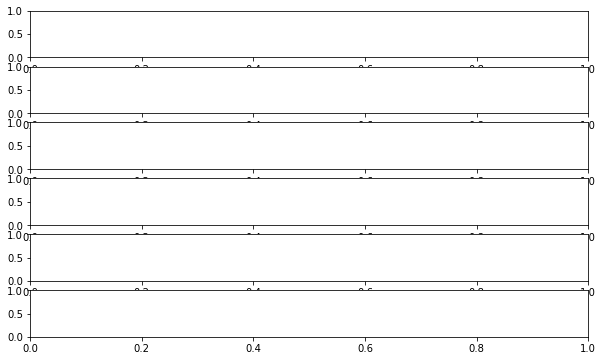

In [5]:
# Diagnostic plots
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 1, figsize = (10,6))
for i in range(6):
    ax = axes.flat[i]
    ax.plot(solved_pH[:, i])
fig.savefig('solved_pH.png', dpi = 600.)
plt.close(fig)

fig, axes = plt.subplots(6, 1, figsize = (10,6))
for i in range(6):
    ax = axes.flat[i]
    ax.plot(solved_err[:, i])
fig.savefig('solved_err.png', dpi = 600.)
plt.close(fig)

fig, axes = plt.subplots(6, 1, figsize = (10,6))
for i in range(6):
    ax = axes.flat[i]
    ax.plot(solved_iter[:, i])
fig.savefig('solved_iter.png', dpi = 600.)
plt.close(fig)

fig, axes = plt.subplots(3, 2, figsize = (20,20))
for i in range(6):
    ax = axes.flat[i]
    ax.plot(beta_h[:, i], solved_err[:, i], 'o')
fig.savefig('solved_betaherr.png', dpi = 600.)
plt.close(fig)

In [ ]:
""" Worker code; only for checking why things are bad
"""

"""import matplotlib.pyplot as plt

layer = 6
i = layer-1
bad = 0 # np.where(solved_err[:, layer-1] > 0.5)[0][0]
j, beta1, beta2, beta3, beta4, beta5 = grid_values[bad]

print(beta1, beta2, beta3, beta4, beta5)

args = b0[layer-1], co2_atm, beta1, beta2, beta3, beta4, beta5, \
       10**log_kex1[layer-1], 10**log_kex2[layer-1], 10**log_kex3[layer-1], \
       10**log_kex4[layer-1], 10**log_kex5[layer-1], i, j
result = find_solution(args)
result

soil_ph = np.linspace(0.5, 0.75, 101)
val = objective(soil_ph, *args[:-2])
plt.plot(soil_ph, val)"""

## Test the accuracy of the LUT by randomly picking some values

In [6]:
from scipy.stats.qmc import LatinHypercube
import pandas as pd
import os
import numpy as np
import itertools as it
import math
import matplotlib.pyplot as plt

eps = 0.01
npts = LatinHypercube(5, seed = 125).random(n = 10000)
npts = np.array([npts[i,:] for i in range(npts.shape[0]) if (np.sum(npts[i,:]) <= 0.95) & \
                (np.min(npts[i,:]) >= eps)])
LUT = pd.read_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 
                               f'dynpH_LUT_{site}.csv'),index_col = 0)

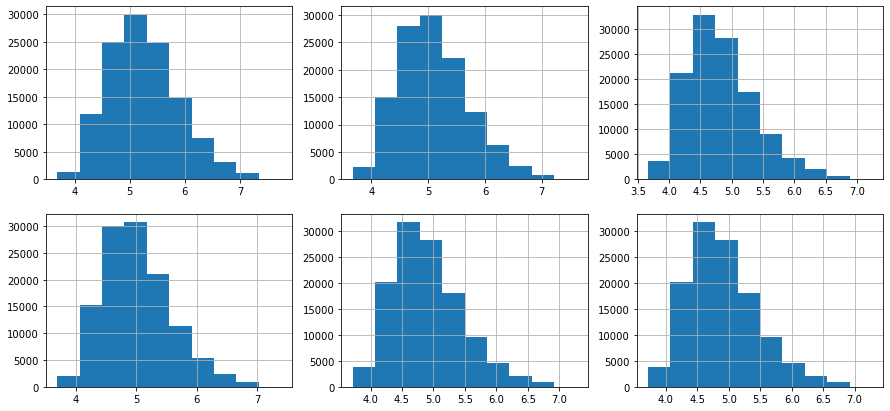

In [7]:
fig, axes = plt.subplots(2, 3, figsize = (15, 7))
for i in range(6):
    ax = axes.flat[i]
    LUT[f'layer{i+1}'].hist(ax = ax)

In [8]:
def pentainear_interpolate(grid_pts, grid_dist, grid_vals):
    """
    Inputs:
    grid_pts - binary number ijkmn, indicates which side
    grid_dist - distance to the lower and upper bounds in grid_pts
    grid_vals - the values at the locations indicated by grid_pts
    """
    # gradually reduce the dimensions

    prev_pts = grid_pts.copy()
    prev_dist = grid_dist.copy()
    prev_interp = grid_vals.copy()

    for bit_position in range(5): # bit position counting from the right

        # find the lower bounds
        bitmask = 1 << bit_position
        left_filter = np.where([not (pg&bitmask) for pg in prev_pts])[0]
        right_filter = np.where([pg&bitmask for pg in prev_pts])[0]

        new_interp = []
        for i in left_filter:
            left = prev_pts[i]
            # check if there is a corresponding upper bound
            right = left^(0 << bit_position)
            temp = np.where([pt == right for pt in prev_pts[right_filter]])[0]
            if len(temp) == 1:
                left_weight = prev_dist[i, 4-bit_position]
                right_weight = prev_dist[right_filter[temp[0]], 4-bit_position]

                left_val = prev_interp[i]
                right_val = prev_interp[right_filter[temp[0]]]

                new_interp.append((left_val*left_weight+right_val*right_weight) / \
                                  (left_weight + right_weight))
            elif len(temp) == 0:
                new_interp.append(prev_interp[i])
            else:
                raise Exception('Too many matching upper bounds')

        prev_pts = prev_pts[left_filter]
        prev_dist = prev_dist[left_filter]
        prev_interp = new_interp
    
    if len(prev_interp) > 1:
        raise Exception('Not boiled down to a single number')

    return prev_interp[0]


def idw_interpolate(grid_dist, grid_vals):
    """
    Inverse distance weighting

    Inputs:
    grid_pts - binary number ijkmn, indicates which side
    grid_dist - distance to the lower and upper bounds in grid_pts
    grid_vals - the values at the locations indicated by grid_pts
    """
    dist = np.sqrt(np.sum(np.power(grid_dist, 2), axis = 1))
    return np.sum(grid_vals * (1/dist)) / np.sum(1/dist)



def apply_LUT(layer, beta_list):
    # note: subtract the minimum offset
    column = f'layer{layer}'

    power = 1.3
    npts = 12 # tested 10-15, 12 is okay
    beta_grid = np.around(np.power(np.linspace(np.power(1e-3, 1/power), 
                                            np.power(0.5, 1/power), npts), power), 3)
    beta_grid = np.concatenate([beta_grid[:-1], 1-beta_grid[::-1]])

    ind_low_high = np.empty([5,2], dtype=int)
    pt_low_high = np.empty([5,2], dtype=float)
    for i in range(5):
        # add eps to avoid 1 being recognized as 0.9999999999999999999
        ind_low_high[i,0] = np.max(np.where(beta_grid <= (beta_list[i]+1e-6))[0])
        ind_low_high[i,1] = np.min(np.where(beta_grid > (beta_list[i]+1e-6))[0])
        pt_low_high[i,0] = beta_grid[ind_low_high[i,0]]
        pt_low_high[i,1] = beta_grid[ind_low_high[i,1]]

    # Get all the nearby points
    grid_pts = [] # indicate low or high end
    grid_dist = [] # distance from the actual point
    grid_vals = [] # values at the points
    for i,j,k,m,n in it.product(range(2), range(2), range(2), range(2), range(2)):
        pt = np.array([pt_low_high[0,i], pt_low_high[1,j], pt_low_high[2,k], \
                       pt_low_high[3,m], pt_low_high[4,n]])
        if np.sum(pt) >= (1 - beta_grid[0]):
            continue # exclude out of range boundaries
        grid_pts.append(int(f"{i}{j}{k}{m}{n}", 2))
        grid_dist.append(np.abs(np.array(beta_list) - pt))
        index = ind_low_high[0,i] * 1e8 + ind_low_high[1,j] * 1e6 + ind_low_high[2,k] * 1e4 + ind_low_high[3,m] * 1e2 + ind_low_high[4,n]
        grid_vals.append(LUT.loc[index, column])
    grid_pts = np.array(grid_pts)
    grid_dist = np.array(grid_dist)
    grid_vals = np.array(grid_vals)

    # result = pentainear_interpolate(grid_pts, grid_dist, grid_vals)
    result = idw_interpolate(grid_dist, grid_vals)

    return result

In [9]:
test_result = np.full([npts.shape[0], 6], np.nan)
test_err = np.full([npts.shape[0], 6], np.nan)
test_correct = np.full([npts.shape[0], 6], np.nan)
for i,j in it.product(range(6), range(npts.shape[0])):
    layer = i + 1
    beta_list = list(npts[j, :])

    result = apply_LUT(layer, beta_list)

    args = b0[layer-1], co2_atm, beta_list[0], beta_list[1], \
           beta_list[2], beta_list[3], beta_list[4], \
           10**log_kex1[layer-1], 10**log_kex2[layer-1], 10**log_kex3[layer-1], \
           10**log_kex4[layer-1], 10**log_kex5[layer-1]

    test_result[j,i] = result
    test_err[j,i] = objective(result, *args)
    test_correct[j,i], _, _, _, _ = find_solution(list(args) + [i, j])

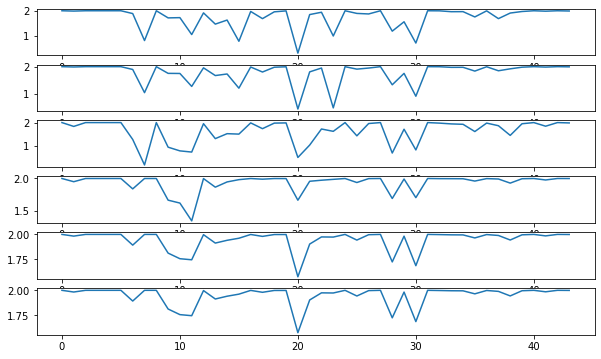

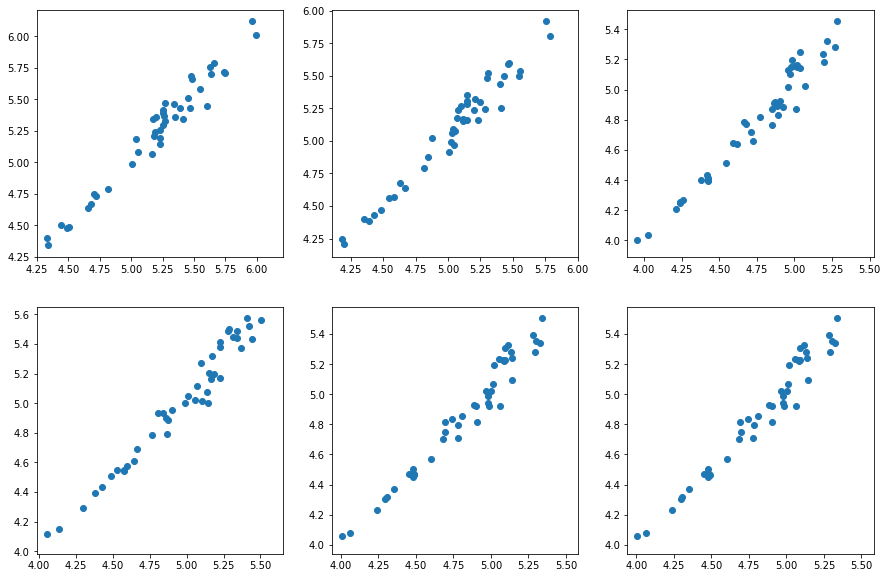

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 1, figsize = (10,6))
for i in range(6):
    axes.flat[i].plot(test_err[:, i])
fig.savefig('test_err.png', dpi = 600.)

fig, axes = plt.subplots(2, 3, figsize = (15,10))
for i in range(6):
    ax = axes.flat[i]
    ax.plot(test_correct[:, i], test_result[:, i], 'o')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.set_xlim([min(xlim[0], ylim[0]), max(xlim[1], ylim[1])])
    ax.set_ylim([min(xlim[0], ylim[0]), max(xlim[1], ylim[1])])
fig.savefig('test_result.png', dpi = 600.)